<a href="https://colab.research.google.com/github/hayannn/AIFFEL_MAIN_QUEST/blob/main/%5BMiniProject%5D%EC%8B%9C%EA%B3%84%EC%97%B4_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 인트로
- 구글 드라이브 연결
- tsfresh 라이브러리 설치

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# !pip3 install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


<br>

# 비정상 데이터를 정상 데이터로 만들기
- 라이브러리 불러오기

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

- 데이터셋 불러오기 & 확인

In [3]:
ap = pd.read_csv('/content/drive/MyDrive/시계열/AirPassengers.csv')

In [4]:
ap.head()

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

- 'Month' 컬럼 삭제

In [5]:
# 'Month' 컬럼 삭제
ap.drop('Month', axis=1, inplace=True)
ap

#Passengers
0            112
1            118
2            132
3            129
4            121
..           ...
139          606
140          508
141          461
142          390
143          432

[144 rows x 1 columns]

- 원본 데이터 시각화
  - 상승 추세를 가지고 있고, 비정상 데이터로 볼 수 있음!

> 분산을 줄이고, 증가 추세를 정리하면 됨

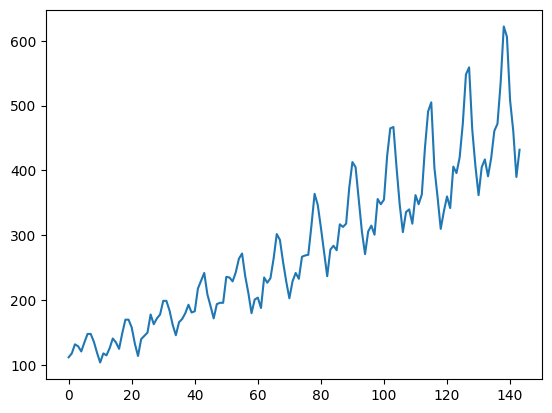

In [6]:
plt.figure()
plt.plot(ap)
plt.show()

<br>

# 분산을 일정하게(로그 변환, log transformation)
- 로그 변환 진행

In [7]:
log_transformed = np.log(ap)
log_transformed

#Passengers
0       4.718499
1       4.770685
2       4.882802
3       4.859812
4       4.795791
..           ...
139     6.406880
140     6.230481
141     6.133398
142     5.966147
143     6.068426

[144 rows x 1 columns]

- 시각화해 확인
  - 분산이 일정해짐(뾰족하게 올라온 정도의 차이를 보면 알 수 있음)

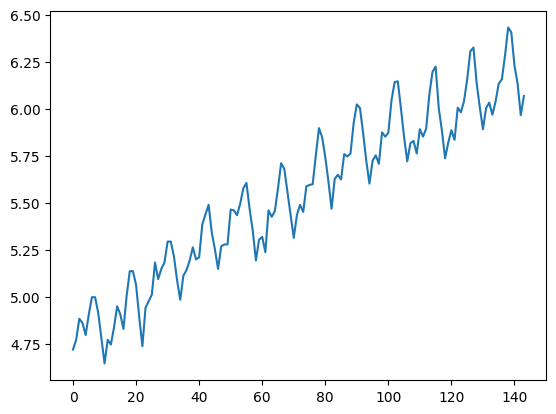

In [8]:
plt.figure()
plt.plot(log_transformed)
plt.show()

<br>

# 차분으로 추세 제거
- diff 함수 사용
  - 차분을 쓰면 데이터 자체가 짧아지기 때문에 데이터를 잘라서 사용!

In [9]:
diffed = log_transformed.diff()[1:]
diffed

#Passengers
1       0.052186
2       0.112117
3      -0.022990
4      -0.064022
5       0.109484
..           ...
139    -0.026060
140    -0.176399
141    -0.097083
142    -0.167251
143     0.102279

[143 rows x 1 columns]

- 분산이 커지는 것 + 증가 추세가 모두 제거되었는지 시각화하여 확인
  - 평균은 0, 분산이 커지지 않는 형태로 정리됨

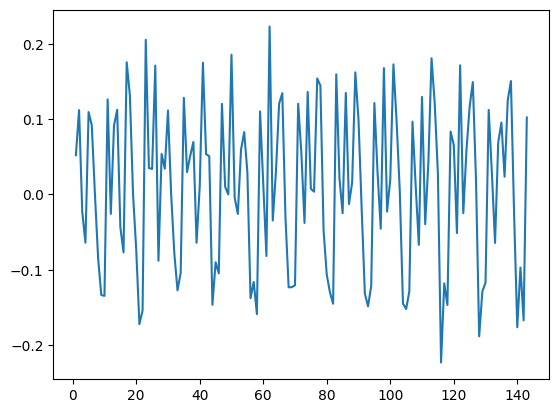

In [10]:
plt.figure()
plt.plot(diffed)
plt.show()

<br>

# 계절 차분으로 계절성 제거
- AirPassengers 데이터셋
  - 12개월(1년)을 주기로 하는 계절성이 포함되어 있음
  - 계절 차분으로 계절성을 제거해야 함

- diff에 12 적용
  - 주기를 12로 하는 계절 차분
  - 차분 시, 데이터의 길이가 짧아지니 Nan 값은 제거 필수

In [11]:
seasonally_diffed = diffed.diff(12)
seasonally_diffed.dropna(inplace = True)
seasonally_diffed

#Passengers
13      0.039164
14      0.000361
15     -0.020496
16     -0.012939
17      0.066148
..           ...
139    -0.045934
140     0.012024
141     0.031830
142    -0.050082
143    -0.009964

[131 rows x 1 columns]

- 시각화
  - 분산이 일정하지 않은 것인지, 스테이블하다고 볼만한 변동성을 가지고 있는 것인지 명확히 구분하기 어려움
  - **검정**을 통한 확인 과정 필요!

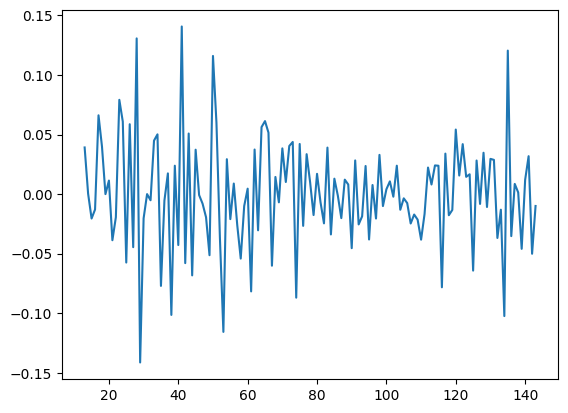

In [12]:
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

<br>

# 검정: 정상성 확인

- `adfuller`
  - statsmodels 모듈의 ADF Test 도구
- 관찰 가능한 값들
  - `adf`
    - 단위근 검정
  - `p-value`
    - 유의 검정
    - 관찰 데이터가 귀무가설이 맞을 경우 -> 통계값 1이 실제 관측 값 이상일 확률을 구함
  - `usedlag`
    - 시차 수(사용된 경우를 뜻함)
  - `nobs`
    - ADF 회귀, 임계값 계산에 사용된 관측치 수
  - `critical values`
    - 임계값
    - 1%, 5%, 10% 수준
  - `icbest`
    - lag 길이 자동 결정: autolag
      - autolag를 none으로 지정하지❌ -> 최대화된 정보를 기준으로 함

- ADF 검정 통계량, P-value 2가지만 확인

In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x):
    stat, p_value, lags, nobs, crit, icb = adfuller(x)
    print('ADF statistics')
    print(stat)

    print('P-value')
    print(p_value)

- adf 테스트 수행
  - ADF statistics 절댓값 기준 : 크면 클 수록 귀무가설 기각 확률 높아짐
  - P-value : 귀무가설 기각 확률(0.05보다 작으면 귀무가설 기각, 시계열은 정상적이라고 판단)

In [14]:
adf_test(seasonally_diffed)

ADF statistics
-4.4433249418311425
P-value
0.00024859123113838495


- 결론
  - **귀무가설(단위근 존재, 비정상성)을 기각**할 수 있음
  - 즉, 시계열 데이터는 정상성을 가진다고 결론!(**대립가설 채택**)

<br>

# 시계열 분류 진행

## 데이터 전처리(다운로드, 가공, 나누기)

- 데이터 다운로드 및 확인
  - id와 time을 제외한 6개 컬럼 X 변수가 나타남을 알 수 있음

In [17]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [18]:
timeseries

id  time  F_x  F_y  F_z  T_x  T_y  T_z
0      1     0   -1   -1   63   -3   -1    0
1      1     1    0    0   62   -3   -1    0
2      1     2   -1   -1   61   -3    0    0
3      1     3   -1   -1   63   -2   -1    0
4      1     4   -1   -1   63   -3   -1    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[1320 rows x 8 columns]

In [19]:
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

- 데이터셋 가공

In [20]:
def custom_classification_split(x,y,test_size=0.3):

    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()

    y_train = y.drop(id_list)
    y_test = y.iloc[id_list].sort_index()
    X_train = timeseries[~timeseries['id'].isin(id_list)]
    X_test = timeseries[timeseries['id'].isin(id_list)]

    return X_train, y_train, X_test, y_test

- 데이터셋 나누기
  - 테스트 데이터셋 비율을 0.25로 지정하기

In [21]:
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size=0.25)

- EfficientParameters 사용
  - 시간이 오래걸리는(계산 비용이 높음) calculator를 제외하고 생성

In [22]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

<br>

## Feature extraction

In [23]:
comprehensive_features_train = extract_features(
                                    X_train,
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 402/402 [00:47<00:00,  8.40it/s]


In [26]:
comprehensive_features_test = extract_features(
                                    X_test,
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 126/126 [00:14<00:00,  8.81it/s]


<br>

## impute
- 이 라이브러리를 사용하면 간단하게 데이터 전처리가 가능함

In [24]:
# train 데이터
impute(comprehensive_features_train)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


F_x__variance_larger_than_standard_deviation  F_x__has_duplicate_max  \
6                                            1.0                     1.0   
7                                            0.0                     1.0   
8                                            1.0                     0.0   
9                                            1.0                     0.0   
10                                           0.0                     0.0   
..                                           ...                     ...   
84                                           1.0                     1.0   
85                                           1.0                     0.0   
86                                           1.0                     0.0   
87                                           1.0                     1.0   
88                                           1.0                     0.0   

    F_x__has_duplicate_min  F_x__has_duplicate  F_x__sum_values  \
6                      1.0                 1.0            -15.0   
7                      0.0                 1.0            -13.0   
8                      1.0                 1.0            -10.0   
9                      0.0                 1.0            -10.0   
10                     1.0                 1.0            -14.0   
..                     ...                 ...              ...   
84                     0.0                 1.0          -1073.0   
85                     1.0                 1.0            143.0   
86                     0.0                 0.0            961.0   
87                     0.0                 1.0           4509.0   
88                     1.0                 1.0           -143.0   

    F_x__abs_energy  F_x__mean_abs_change  F_x__mean_change  \
6              39.0              1.714286          0.142857   
7              21.0              0.928571          0.214286   
8              26.0              1.142857         -0.142857   
9              24.0              1.428571          0.000000   
10             14.0              0.142857          0.000000   
..              ...                   ...               ...   
84          96833.0              7.142857         -5.428571   
85           1683.0              1.357143          1.071429   
86          83497.0              9.071429          9.071429   
87        1405437.0             12.928571         12.214286   
88           1427.0              0.785714         -0.500000   

    F_x__mean_second_derivative_central  F_x__median  ...  \
6                              0.153846         -1.0  ...   
7                             -0.076923         -1.0  ...   
8                              0.192308         -1.0  ...   
9                             -0.076923         -1.0  ...   
10                             0.000000         -1.0  ...   
..                                  ...          ...  ...   
84                            -0.038462        -98.0  ...   
85                             0.076923          8.0  ...   
86                             0.807692         52.0  ...   
87                            -1.038462        338.0  ...   
88                             0.038462         -9.0  ...   

    T_z__fourier_entropy__bins_5  T_z__fourier_entropy__bins_10  \
6                       0.974315                       1.213008   
7                       1.255482                       1.494175   
8                       1.494175                       1.732868   
9                       1.255482                       1.494175   
10                      0.937285                       1.213008   
..                           ...                            ...   
84                      0.735622                       0.735622   
85                      0.735622                       0.735622   
86                      0.735622                       1.073543   
87                      0.735622                       0.735622   
88                      1.255482                       1.49

In [27]:
# test 데이터
impute(comprehensive_features_test)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


F_x__variance_larger_than_standard_deviation  F_x__has_duplicate_max  \
1                                            0.0                     0.0   
2                                            0.0                     1.0   
3                                            0.0                     0.0   
4                                            0.0                     1.0   
5                                            0.0                     0.0   
19                                           1.0                     0.0   
20                                           1.0                     0.0   
21                                           1.0                     0.0   
22                                           1.0                     0.0   
23                                           1.0                     0.0   
24                                           1.0                     0.0   
25                                           1.0                     0.0   
26                                           1.0                     0.0   
27                                           1.0                     1.0   
28                                           1.0                     0.0   
29                                           1.0                     0.0   
30                                           1.0                     0.0   
31                                           1.0                     0.0   
32                                           1.0                     0.0   
33                                           1.0                     0.0   
34                                           1.0                     0.0   

    F_x__has_duplicate_min  F_x__has_duplicate  F_x__sum_values  \
1                      1.0                 1.0            -14.0   
2                      1.0                 1.0            -13.0   
3                      1.0                 1.0            -10.0   
4                      1.0                 1.0             -6.0   
5                      0.0                 1.0             -9.0   
19                     0.0                 1.0             99.0   
20                     1.0                 1.0            155.0   
21                     0.0                 1.0           -171.0   
22                     0.0                 1.0            102.0   
23                     0.0                 1.0             67.0   
24                     0.0                 1.0           -338.0   
25                     0.0                 1.0           -123.0   
26                     0.0                 1.0            -63.0   
27                     0.0                 1.0             50.0   
28                     0.0                 1.0            -28.0   
29                     0.0                 1.0            -51.0   
30                     1.0                 1.0             36.0   
31                     0.0                 1.0             43.0   
32                     0.0                 1.0            -15.0   
33                     0.0                 1.0             22.0   
34                     0.0                 1.0            173.0   

    F_x__abs_energy  F_x__mean_abs_change  F_x__mean_change  \
1              14.0              0.142857          0.000000   
2              25.0              1.000000          0.000000   
3              12.0              0.714286          0.000000   
4              16.0              1.214286         -0.071429   
5              17.0              0.928571         -0.071429   
19           6109.0             13.928571         -1.928571   
20          34455.0             16.714286        -13.142857   
21          16495.0             20.928571          1.785714   
22          12700.0             10.785714         -8.071429   
23          10593.0             15.142857         -7.000000   
24          37100.0             13.214286          9.071429   
25           6853.0              7.785714          5.214286   
26          18717.0             14.21

<br>

## 모델 적용: RandomForest, XGBoost -> score로 평가

- RandomForest

In [28]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3)

rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

- 성능 확인
  - 강의에서는 0.6 정도의 성능이 추출되었으나, 실제 코랩에서는 0.85정도로 추출됨

In [29]:
rf_clf.score(comprehensive_features_test, y_test)

0.8571428571428571

- XGBoost

In [30]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

xgb_clf.fit(comprehensive_features_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

- 1.0 출력됨
  - 100%로 완벽하게 분류 문제가 해결됨

In [31]:
xgb_clf.score(comprehensive_features_test, y_test)

1.0

<br>

# 추가) Logistic Regression

- 성능이 가장 좋지 않음
  - 튜닝 or 해당 모델을 사용하지 않는 방향으로 결정

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg_clf = LogisticRegression(max_iter=1000)
log_reg_clf.fit(comprehensive_features_train, y_train)

LogisticRegression(max_iter=1000)

In [37]:
log_reg_clf.score(comprehensive_features_test, y_test)

0.5714285714285714

## 시각화: XGBoost plot_importance
- 어떤 피쳐가 가장 유의미했는지 파악하기 위해 사용

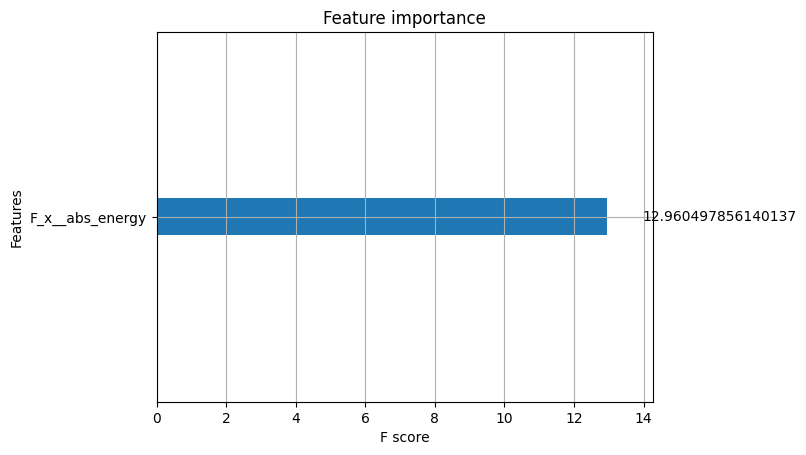

In [32]:
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

In [33]:
sum(xgb_clf.feature_importances_ != 0)

1

<br>

## Classification report(검증 및 분석)

- 고장 유무를 판별하는 기준
  - `F_X_abs_energy` feature임을 알 수 있음

In [34]:
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16.0},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0}}

# 정리) classification report

- Precision
  - 정밀도: 모델이 양성 예측한 것 중에서 실제 양성 비율을 측정
  - True, False 모두 1.0
  - 모든 예측이 정확하게 맞았다는 것을 의미

- Recall
  - 재현율 : 실제 양성 데이터 중 모데링 양성으로 예측한 비율을 측정
  - True, False 모두 1.0
  - 모든 실제 데이터가 정확히 분류되었음을 의미

- F1-Score
  - 정밀도 및 재현율읠 균형 측정
  - True, False 모두 1.0
  - 정밀도, 재현율 모두가 완벽하게 이루어져 이 역시 완벽하게 나옴

- Accuracy
  - 정확도
  - 이 역시 1.0이 나왔음 -> 모든 데이터가 정확하게 잘 분류됨

- support
  - True : 총 16개 데이터
  - False : 총 5개 데이터
  - 모든 예측에 성공

- Macro Avg
  - 성능 지표 평균
  - 1.0으로 추출됨

- Weighted Avg
  - 가중치 평균
  - 1.0으로 추출됨